<a href="https://colab.research.google.com/github/jinjin0309/Final-Team6/blob/main/4%EB%B2%88_%EC%BD%94%EB%93%9C_%EC%A0%95%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd


In [ ]:
df = pd.read_csv('/content/combined_dataset.csv')

In [ ]:
#한글 글씨 폰트 설치
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

# 표에서 ('-') 마이너스 표시
plt.rcParams['axes.unicode_minus'] = False

# 필요한 라이브러리 임포트
import pandas as pd # 데이터 분석 라이브러리
import numpy as np
import matplotlib.pyplot as plt # 시각화 도구 라이브러리1
import seaborn as sns # 시각화 도구 라이브러리2

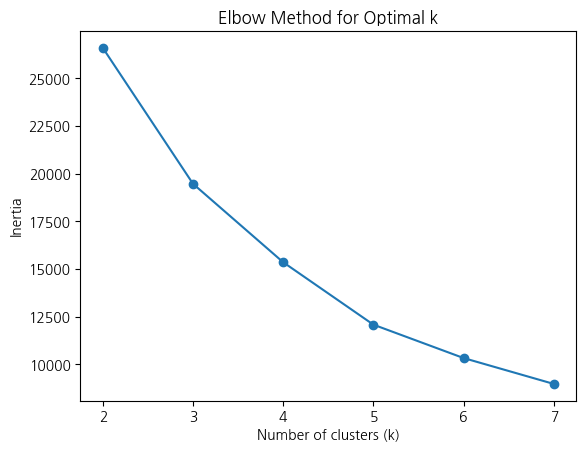

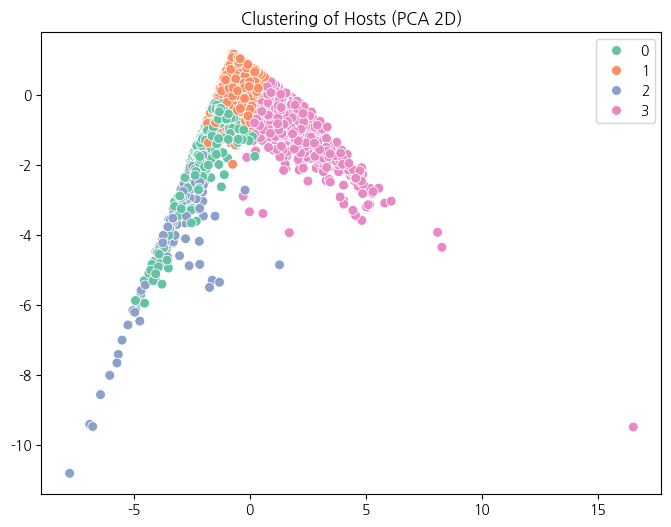

         host_response_rate  number_of_reviews  review_scores_rating  \
cluster                                                                
0                 96.173139           7.953074              3.626683   
1                 98.564317          34.390252              4.777246   
2                 24.000000          23.760976              4.375366   
3                 99.545532         189.033191              4.783826   

         reviews_per_month  
cluster                     
0                 0.902686  
1                 1.295880  
2                 0.505756  
3                 4.500621  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기
df = pd.read_csv("/content/combined_dataset.csv")

# 2. 필요한 변수 선택
features = ["host_response_rate", "number_of_reviews", "review_scores_rating", "reviews_per_month"]
data = df[features].copy()

# 3. host_response_rate: % → 숫자로 변환
data["host_response_rate"] = (
    data["host_response_rate"]
    .str.replace("%", "", regex=False)
    .astype(float)
)

# 4. 결측치 제거 (간단하게 dropna)
data = data.dropna()

# 5. 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

# 6. PCA (시각화 위해 2차원)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 7. 최적 클러스터 개수 찾기 (Elbow Method)
inertia = []
K = range(2, 8)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

# 8. 최적 k로 KMeans
optimal_k = 4  # 예시: elbow plot 보고 수정 가능
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# 9. 결과 저장
data["cluster"] = labels

# 10. 클러스터 시각화
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette="Set2", s=50)
plt.title("Clustering of Hosts (PCA 2D)")
plt.show()

# 11. 각 클러스터별 평균값 확인
cluster_summary = data.groupby("cluster").mean()
print(cluster_summary)


# 주요 흐름
1. 데이터 로드 → 일부 feature 선택
   (host_response_rate, number_of_reviews, review_scores_rating, reviews_per_month)

2. 전처리
   - host_response_rate: % → 숫자 변환
   - 결측치: dropna()

3. 표준화 + PCA (2차원으로 축소)

4. Elbow Method (inertia 그래프) → 사람이 직접 optimal_k 결정

5. KMeans 실행 → cluster 라벨 추가

6. 시각화: PCA 산점도

7. 클러스터별 평균값 계산 (해석은 사용자가 따로)


--------------------------------

✅ 특징

-간단: 꼭 필요한 변수만 사용

-결측치 단순 처리 (삭제)

-최적 k는 사용자가 elbow plot 보고 직접 고름

-결과물:

- PCA 2D 산점도

- 각 클러스터 평균값 테이블

👉 학습용/탐색적 분석에 적합

Original shape: (11446, 75)
Numeric columns: 41
Removing zero-variance columns: ['neighbourhood_group_cleansed', 'calendar_updated', 'license', 'id_missing', 'scrape_id_missing', 'host_id_missing', 'host_listings_count_missing', 'host_total_listings_count_missing', 'latitude_missing', 'longitude_missing', 'accommodates_missing', 'minimum_nights_missing', 'maximum_nights_missing', 'availability_30_missing', 'availability_60_missing', 'availability_90_missing', 'availability_365_missing', 'number_of_reviews_missing', 'number_of_reviews_ltm_missing', 'number_of_reviews_l30d_missing', 'calculated_host_listings_count_missing', 'calculated_host_listings_count_entire_homes_missing', 'calculated_host_listings_count_private_rooms_missing', 'calculated_host_listings_count_shared_rooms_missing']
Final shape after preprocessing: (11446, 58)
Optimal clusters: 2


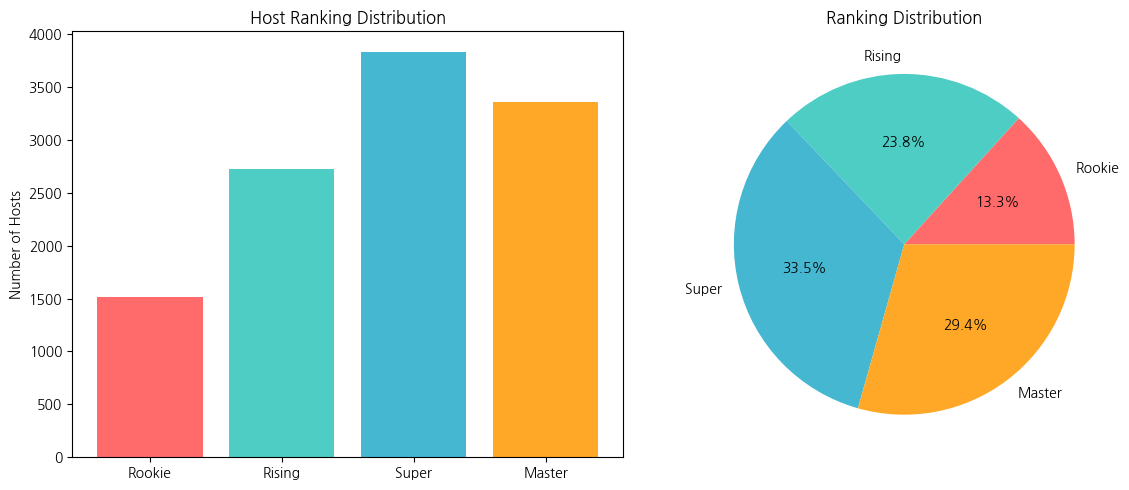

Rookie: 1519 hosts (13.3%)
Rising: 2729 hosts (23.8%)
Super: 3835 hosts (33.5%)
Master: 3363 hosts (29.4%)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

class SimpleSelfSupervised:
    def __init__(self):
        self.scaler = StandardScaler()

    def run_analysis(self, file_path="/content/combined_dataset.csv"):
        # 1. 데이터 로드
        df = pd.read_csv(file_path)
        print(f"Original shape: {df.shape}")

        # 2. 수치형 컬럼만 선택
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        print(f"Numeric columns: {len(numeric_cols)}")

        data = df[numeric_cols].copy()

        # 무한대값 처리
        data = data.replace([np.inf, -np.inf], np.nan)

        # 3. 결측치 안전 처리
        for col in data.columns:
            # NaN 여부를 의미 있는 정보로 추가
            data[f"{col}_missing"] = data[col].isna().astype(int)

            # 결측은 분포 기반 랜덤 샘플링으로 채우기
            not_na = data[col].dropna()
            if len(not_na) > 0:
                na_count = data[col].isna().sum()
                if na_count > 0:
                    sampled_values = not_na.sample(na_count, replace=True, random_state=42).values
                    data.loc[data[col].isna(), col] = sampled_values
            else:
                # 모든 값이 NaN이면 0으로
                data[col] = 0

        # 4. 분산이 0인 컬럼 제거
        zero_var_cols = data.columns[data.var() == 0].tolist()
        if zero_var_cols:
            print(f"Removing zero-variance columns: {zero_var_cols}")
            data = data.drop(columns=zero_var_cols)

        print(f"Final shape after preprocessing: {data.shape}")
        if len(data.columns) == 0:
            raise ValueError("No valid columns remaining!")

        # 5. 정규화 + PCA
        data_scaled = self.scaler.fit_transform(data)
        pca = PCA(n_components=min(0.95, data.shape[1]-1))
        data_pca = pca.fit_transform(data_scaled)

        # 6. 최적 클러스터 수 찾기
        best_k = self.find_optimal_k(data_pca)
        print(f"Optimal clusters: {best_k}")

        # 7. 클러스터링
        kmeans = KMeans(n_clusters=best_k, random_state=42)
        clusters = kmeans.fit_predict(data_pca)

        # 8. 4개 등급으로 조정
        if best_k != 4:
            clusters = self.adjust_to_4_clusters(data_pca, clusters, best_k)

        # 9. 등급명 할당
        rankings = self.assign_rankings(clusters, data_pca)

        # 10. 시각화
        self.visualize(clusters, rankings)

        # 11. 데이터에 등급 추가
        rank_names = ['Rookie', 'Rising', 'Super', 'Master']
        df['ranking'] = [rank_names[r] for r in rankings]

        for rank in rank_names:
            count = (df['ranking'] == rank).sum()
            print(f"{rank}: {count} hosts ({count/len(df)*100:.1f}%)")

        return df

    def find_optimal_k(self, data):
        scores = []
        for k in range(2, min(11, len(data)//50 + 2)):
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(data)
            scores.append(silhouette_score(data, labels))
        return range(2, len(scores)+2)[np.argmax(scores)]

    def adjust_to_4_clusters(self, data, labels, current_k):
        new_labels = labels.copy()

        if current_k > 4:
            unique_labels = np.unique(labels)
            centroids = np.array([data[labels==i].mean(axis=0) for i in unique_labels])
            distances = squareform(pdist(centroids))
            for _ in range(current_k - 4):
                np.fill_diagonal(distances, np.inf)
                i, j = np.unravel_index(np.argmin(distances), distances.shape)
                new_labels[new_labels == unique_labels[j]] = unique_labels[i]
                distances[j, :] = distances[:, j] = np.inf
            unique_new = np.unique(new_labels)
            new_labels = np.array([dict(zip(unique_new, range(4)))[x] for x in new_labels])

        elif current_k < 4:
            for _ in range(4 - current_k):
                unique, counts = np.unique(new_labels, return_counts=True)
                largest = unique[np.argmax(counts)]
                cluster_data = data[new_labels == largest]
                if len(cluster_data) > 10:
                    sub_kmeans = KMeans(n_clusters=2, random_state=42)
                    sub_labels = sub_kmeans.fit_predict(cluster_data)
                    mask = (new_labels == largest)
                    new_labels[mask] = largest
                    new_labels[np.where(mask)[0][sub_labels == 1]] = new_labels.max() + 1
        return new_labels

    def assign_rankings(self, labels, data_pca):
        centralities = []
        for i in range(4):
            cluster_data = data_pca[labels == i]
            centrality = np.mean(np.linalg.norm(cluster_data, axis=1))
            centralities.append(centrality)
        rank_order = np.argsort(centralities)[::-1]
        label_to_rank = {rank_order[i]: i for i in range(4)}
        return np.array([label_to_rank[label] for label in labels])

    def visualize(self, clusters, rankings):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        rank_names = ['Rookie', 'Rising', 'Super', 'Master']
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA726']
        unique, counts = np.unique(rankings, return_counts=True)
        ax1.bar([rank_names[i] for i in unique], counts, color=[colors[i] for i in unique])
        ax1.set_title('Host Ranking Distribution')
        ax1.set_ylabel('Number of Hosts')
        ax2.pie(counts, labels=[rank_names[i] for i in unique], colors=[colors[i] for i in unique], autopct='%1.1f%%')
        ax2.set_title('Ranking Distribution')
        plt.tight_layout()
        plt.show()

# 실행
def run():
    model = SimpleSelfSupervised()
    results = model.run_analysis("/content/combined_dataset.csv")  # 경로 고정
    return results

if __name__ == "__main__":
    df_with_rankings = run()


# 주요 흐름
1. 데이터 로드 → 모든 수치형 컬럼 선택

2. 전처리
   - 무한대값 → NaN
   - NaN 여부를 새로운 피처(col_missing)로 추가
   - 결측값: 랜덤 샘플링 기반 채우기
   - 분산 0인 컬럼 제거

3. 표준화 + PCA (설명분산 95%까지 유지)

4. 최적 k 자동 탐색 (Silhouette Score)

5. KMeans 실행

6. 클러스터 개수를 무조건 4개로 조정
   - k > 4: 가까운 클러스터 합침
   - k < 4: 큰 클러스터 쪼개기

7. 등급 순위 매기기
   - 클러스터 중심과의 평균 거리(centrality) 기준
   - 거리가 클수록 상위 등급
   - 등급명: Rookie, Rising, Super, Master

8. 시각화
   - 등급별 막대그래프 + 파이차트

9. 최종 데이터 반환
   - df['ranking'] 컬럼 추가
   - 각 등급 인원수와 비율 출력


In [ ]:
--------------------------

특징

-자동화: feature 선택, 결측치 처리, k 선택까지 다 알아서 함

-견고함: 결측치 보존 정보 추가 + 랜덤 샘플링 대체 + 무의미 변수 제거

-무조건 4등급 체계로 맞춤 (Rookie ~ Master)

-결과물:

- 등급별 인원수/비율

- 막대그래프 & 파이차트

- 원본 df에 등급 컬럼 추가

👉 실제 서비스/리포트용에 적합

SyntaxError: invalid character '👉' (U+1F449) (ipython-input-101628099.py, line 19)

----------------------------------

코드 1은 “기본 실습용”

코드 2는 “실제 자동화된 등급 시스템 구축용”